# Probing the baryon content of a galaxy cluster

The aim of this tutorial is to take you through the basic methods with which XGA can probe the hot gas that makes of the intra-cluster medium (ICM). We'll focus on measuring the radial gas density profiles of a sample of galaxy clusters here, then move on to using density profiles to measure gas masses.

Please note that I will not really be fully explaining how the methods to measure gas density from clusters work in this tutorial, that is the subject of a [section in the 'Under the Hood' section](../techniques/density_profiles_from_xray.html), where the maths and concepts are detailed.

In [16]:
from xga.samples import ClusterSample
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.imagetools.psf import rl_psf
from xga.models import KingProfile1D

from astropy.units import Quantity
import numpy as np
import pandas as pd

## Defining a sample of galaxy clusters

I'm using the same sample of galaxy clusters that I used in the [spectroscopy tutorial](../tutorials/spectroscopy.html) for the sake of convenience. I've chosen to use a ClusterSample rather than a GalaxyCluster as there are extra, convenient, methods built into ClusterSamples for dealing with samples of gas masses, though I will also show how you interact with gas density profiles/gas masses for an individual cluster:

In [2]:
# Setting up the column names and numpy array that go into the Pandas dataframe
column_names = ['name', 'ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']
cluster_data = np.array([['XCSSDSS-124', 0.80057775, -6.0918182, 0.251, 1220.11, 1777.06, 109.55, 4.49],
                         ['XCSSDSS-2789', 0.95553986, 2.068019, 0.11, 1039.14, 1519.79, 38.90, 2.83],
                         ['XCSSDSS-290', 2.7226392, 29.161021, 0.338, 935.58, 1359.37, 105.10, 5.99],
                         ['XCSSDSS-134', 4.9083898, 3.6098177, 0.273, 1157.04, 1684.15, 108.60, 4.79]])

# Possibly I'm overcomplicating this by making it into a dataframe, but it is an excellent data structure,
#  and one that is very commonly used in my own analyses.
sample_df = pd.DataFrame(data=cluster_data, columns=column_names)
sample_df[['ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']] = \
    sample_df[['ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']].astype(float)

#REMOVE THIS FOR DEPLOYMENT
sample_df = sample_df[:2]

# Defining the sample of four XCS-SDSS galaxy clusters
demo_smp = ClusterSample(sample_df["ra"].values, sample_df["dec"].values, sample_df["z"].values, 
                         sample_df["name"].values, r200=Quantity(sample_df["r200"].values, "kpc"),
                         r500=Quantity(sample_df["r500"].values, 'kpc'), richness=sample_df['richness'].values, 
                         richness_err=sample_df['richness_err'].values)

Setting up Galaxy Clusters: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


## Surface brightness based gas density measurement

This first method uses the surface brightness profile of a cluster, as well as assumptions about its geometry and plasma emission, to measure the three-dimensional gas density profile. There are two broad steps to this process; we make a surface brightness profile of the cluster, fit a model to it, then use that to deduce the three-dimensional emissivity and then we use a plasma emission model, combined with an absorption model, to convert that emissivity into a density.

Of course the implementation (and details) of this method are more complicated than that makes it sound, but a convenience function has been added to XGA that goes through the whole process, `inv_abel_fitted_model()`, for which the full docstring can be found [here](../../xga.sourcetools.html#xga.sourcetools.density.inv_abel_fitted_model).

### PSF correction

As we are likely to be using small annular bins for the brightness profile, and the XMM-Newton telescope has a [non-negligible](https://xmm-tools.cosmos.esa.int/external/xmm_user_support/documentation/uhb/onaxisxraypsf.html) point spread function ([PSF](https://www.zeiss.com/microscopy/int/solutions/reference/basic-microscopy/the-point-spread-function.html)), we have to account for this effect with a correction, bearing in mind that these effects also vary spatially. The PSFs of the three XMM cameras have been well studied, with [Read et al. (2011)](https://ui.adsabs.harvard.edu/link_gateway/2011A&A...534A..34R/doi:10.1051/0004-6361/201117525) producing comprehensive models that take into account the complex two-dimensional structure of the effects. In XGA we can use those models to correct images directly, and prior to the generation of a brightness profile, whereas previously a one-dimensional model was used to correct after the profile had been generated.

A full explanation of how this process works can be found in [PSF correction of XMM images](../techniques/psf_correction_of_images.html) in the 'Under the Hood' section, and the documentation for the correction function is [here](../../xga.imagetools.html#xga.imagetools.psf.rl_psf). Please note that the `inv_abel_fitted_model()` function will automatically generate and use PSF corrected images, but I'm calling the correction function here manually as a demonstration (you can set custom chunking and iteration factors in the function call but I'm leaving it default). You can also automatically run PSF correction when a ClusterSample is declared by setting `psf_corr=True`:

In [3]:
rl_psf(demo_smp)

Generating products of type(s) image: 100%|██████████| 4/4 [00:00<00:00,  8.47it/s]


We can see the effect of this correction on the images and brightness profiles, with a demonstration using the first cluster in the sample (XCSSDSS-124):

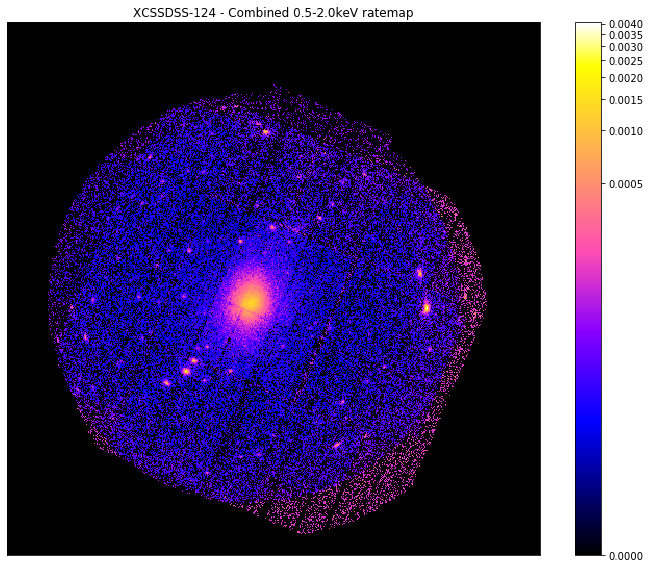

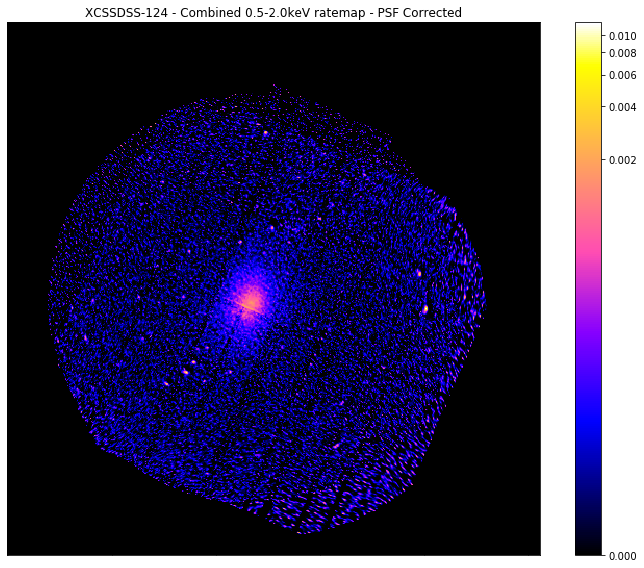

In [10]:
rt = demo_smp[0].get_combined_ratemaps(psf_corr=False)
rt.view()

rt = demo_smp[0].get_combined_ratemaps(psf_corr=True)
rt.view()

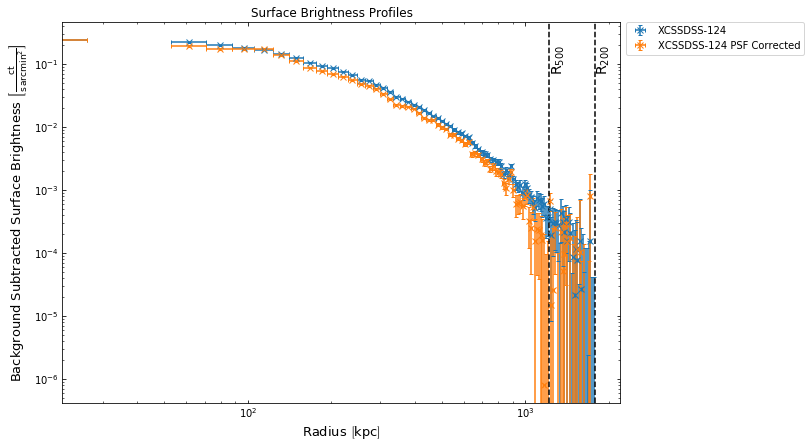

In [13]:
demo_smp[0].view_brightness_profile('r200')

### Running the density calculation function

There are many arguments that can be passed to this function, and I'm not going to explain them all here, please see the [function documentation](../../xga.sourcetools.html#xga.sourcetools.density.inv_abel_fitted_model) for explanations. However, I will go through the most important arguments you need to consider when running this function:

* `model` - This is the model that will be fitted to the surface brightness profile, and then transformed to infer the three-dimensional countrate per volume element radial distribution. This can either be a model name, a list of model names (if dealing with a sample), a model instance (see [profile tutorial](../advanced_tutorials/intro_to_profiles.html) for context), or a list of model instances (if dealing with a sample).
* `outer_radius` - The radius (or radii, if we're dealing with a sample) out to which the profiles should be generated. This has to be carefully balanced, as you don't want to choose too small a radius and have too much cluster emission emission in the background annulus, and you don't want to choose too large a radius and start hitting the edge of the detector.
* `num_dens` - If this is true then a number density profile will be calculated, if False then a mass density profile.
* `obs_id` and `inst` - You can pass an ObsID and instrument (or lists of these, if dealing with a sample) if you wish to specify a single image to measure density with.
* `conv_temp` - The temperature used for the plasma emission model can be specified manually (for samples as well as individual clusters). The default behaviour is to measure the temperature within the `conv_outer_radius` and use that, and if that fit fails then to assume the temperature is 3keV.
* `conv_outer_radius` - The radius (radii for samples) for which spectra are generated (and fitted if `conv_temp` isn't set) to calculate the conversion between count-rate per volume element and density, which involves the use of the ARFs (see the [spectroscopic tutorial](../tutorials/spectroscopy.html) for an explanation)

Here I generate profiles out to 1.2R$_{500}$ of each cluster, and use spectra generated within R$_{500}$ to measure the temperature and calculate the conversion. I also choose to fit a [beta](../../xga.models.html#xga.models.sb.BetaProfile1D) profile, and increase the number of steps the MCMC samplers will take from the default (20000) to 40000. This function also returns a list of profiles (if a profile fails to generate for some reason a None will take the profile's place in the list), as well as storing the profiles within the source objects in the sample:

In [ ]:
sb_d_profs = inv_abel_fitted_model(demo_smp, 'beta', outer_radius=1.2*demo_smp.r500, conv_outer_radius='r500', 
                                   num_steps=40000)
sb_d_profs

## Annular spectra gas density method

The alternative method is based on a similar idea, but instead we generate annular spectra, fit an absorbed plasma model to each annulus, and use the normalisation of that model (and assumptions about the cluster geometry) to measure the density. The main disadvantage of this method is that you require a lot of X-ray counts in a spectrum to get a good fit, so the annuli must be **much** larger than the brightness profile method. However, for clusters with high enough quality data this method can be a check of the results measured from the surface brightness profile method.

This method doesn't really require any PSF correction due to the large annuli required for the annular spectra to have enough counts for a successful fit, and we will set a minimum size to ensure that PSF considerations are unnecessary. Again there are more arguments for this function than I want to go into here, but you can read about all of them in the full [function documentation](../../xga.sourcetools.html#xga.sourcetools.density.ann_spectra_apec_norm). I will again take you through the most important arguments, however:

* `outer_radius` - The radius (or radii, if we're dealing with a sample) out to which the profiles should be generated. This has to be carefully balanced, as you don't want to choose too small a radius and have too much cluster emission emission in the background annulus, and you don't want to choose too large a radius and start hitting the edge of the detector.
* `num_dens` - If this is true then a number density profile will be calculated, if False then a mass density profile.
* `annulus_method` - The method by which the annuli are designated, the default is a minimimum signal to noise value (`min_snr`) which is targetted, though if it cannot be attained in all annuli the function will allow the number of annuli to drop to four, use them, and give a warning to the user.
* `min_snr` - The minimum signal to noise target for annuli.
* `min_width` - The minimum width of each annulus, default is 20 arcseconds to try and remove the need for accounting for PSF effects.
* `use_worst` - If set to True then the annuli generation algorithm will use the 'worst' observation (defined by global signal to noise of the cluster), to decide how big to make the annuli.

In [ ]:
as_d_profs = ann_spectra_apec_norm(demo_smp, 1.2*demo_smp.r500, min_snr=30)
as_d_profs

## Viewing the gas density profiles

The [profile tutorial](../advanced_tutorials/intro_to_profiles.html) demonstrated how to use the profile view method to make a visualisation of the radial profile data, as well as the fact that we can add two compatible profiles together to compare them. I will use that ability again here to view (and compare) the density profiles from the different methods. At first I will simply draw the profiles from the lists which were outputted by the measurement functions, but then I will demonstrate how to retrieve a profile directly from a source:

In [ ]:
for src_ind in range(0, len(demo_smp)):
    (sb_d_profs+as_d_profs).view()

We can also view the surface brightness profiles that went into the creation of the density profiles from the first method, by cycling through them and using the `generation_profile` property:

In [ ]:
for d_prof in sb_d_profs:
    d_prof.generation_profile.view()

## Measuring a gas mass from density profiles

For a gas mass to be measured, we first must fit a model to the density profile, again using the profile `fit()` method. After this process has run through, we will then be able to request a gas mas at any radius we like, and have both an individual gas mass/uncertainty returned, and a gas mass distribution.

I am choosing to fit a simple King function to the density profile, and though I have imported the `KingProfile1D` class, I've only done this to show you the output of the `info()` method, and I won't actually be setting up a custom instance:

In [18]:
KingProfile1D().info('grid')

+-----------------+-------------------------------------------------------------------------+
| King Profile    |                                                                         |
+=================+=========================================================================+
| DESCRIBES       | Gas Density                                                             |
+-----------------+-------------------------------------------------------------------------+
| UNIT            | solMass / Mpc3                                                          |
+-----------------+-------------------------------------------------------------------------+
| PARAMETERS      | beta, r_core, norm                                                      |
+-----------------+-------------------------------------------------------------------------+
| PARAMETER UNITS | , kpc, solMass / Mpc3                                                   |
+-----------------+-----------------------------------------

Now I'm going to demonstrate how you can retrieve a gas density profile from a source object directly, rather than relying on the list output by the density profile generation functions. When you've only generated one density profile for a given source, just calling `get_density_profiles()` will return that for you without any extra information being passed in. If you've generated multiple profiles (be it with different methods or simply for different outermost radii) like we've done in this demonstration, then it will return a list containing all of the available profiles for the source.

As such, we'll need to pass in some extra information to retrieve the exact profile we want to fit a model to:

In [19]:
cur_dens_prof = demo_smp[0].get_density_profiles()

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_all_peaks',
 '_alt_match_regions',
 '_ang_diam_dist',
 '_att_files',
 '_back_inn_factor',
 '_back_out_factor',
 '_chosen_peak_cluster',
 '_cosmo',
 '_custom_region_radius',
 '_default_coord',
 '_detected',
 '_disassociated',
 '_disassociated_obs',
 '_dof',
 '_existing_xga_products',
 '_fit_results',
 '_generate_interloper_mask',
 '_get_phot_prod',
 '_get_prof_prod',
 '_get_spec_based_profiles',
 '_initial_products',
 '_initial_region_matches',
 '_initial_regions',
 '_instruments',
 '_interloper_masks',
 '_interloper_regions',
 '_interloper_sas_string',
 '_load_fits',
 '_load_products',
 '_load_regions',
 '_l